<a href="https://colab.research.google.com/github/samipn/clustering_demos/blob/main/timeseries_clustering_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment (f): Time Series Clustering using Pretrained-like Embeddings

This notebook creates synthetic time series, learns an autoencoder as a feature extractor, and clusters the learned embeddings with K-Means. Clustering quality is measured with silhouette score and ARI.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from tensorflow.keras import layers, models

plt.rcParams["figure.figsize"] = (10, 4)
np.random.seed(42)


In [2]:
# Create synthetic time series: 3 pattern types, length 100
n_series_per_cluster = 200
timesteps = 100
t = np.linspace(0, 1, timesteps)

def cluster1(n):
    return np.sin(2 * np.pi * 5 * t)[None, :] + 0.1 * np.random.randn(n, timesteps)

def cluster2(n):
    base = np.sign(np.sin(2 * np.pi * 3 * t))
    return base[None, :] + 0.1 * np.random.randn(n, timesteps)

def cluster3(n):
    base = 2 * (t - np.floor(t + 0.5))
    return base[None, :] + 0.1 * np.random.randn(n, timesteps)

X1 = cluster1(n_series_per_cluster)
X2 = cluster2(n_series_per_cluster)
X3 = cluster3(n_series_per_cluster)

X = np.vstack([X1, X2, X3]).astype("float32")
y_true = np.array(
    [0]*n_series_per_cluster +
    [1]*n_series_per_cluster +
    [2]*n_series_per_cluster
)

# reshape for Keras: (n_samples, timesteps, 1)
X_ts = X[..., None]

print("X_ts shape:", X_ts.shape)


X_ts shape: (600, 100, 1)


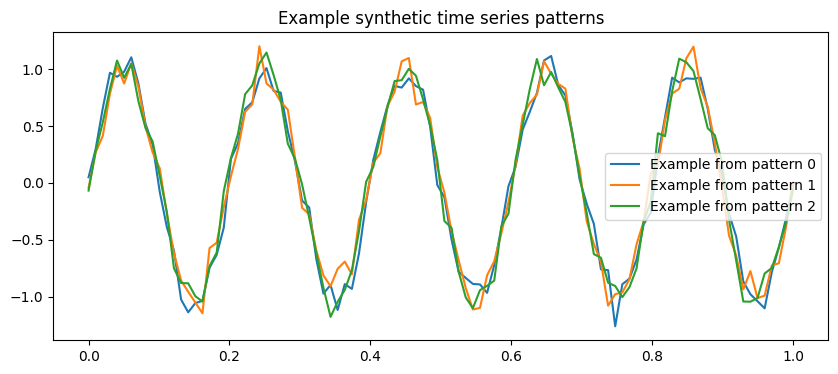

In [3]:
# Visualize some time series patterns
plt.figure(figsize=(10, 4))
for i in range(3):
    plt.plot(t, X_ts[i * 50].squeeze(), label=f"Example from pattern {i}")
plt.legend()
plt.title("Example synthetic time series patterns")
plt.show()


In [4]:
# Build and train an autoencoder (used as pretrained-like encoder)
latent_dim = 8

inputs = layers.Input(shape=(timesteps, 1))
x = layers.Conv1D(16, 3, activation='relu', padding='same')(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(32, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Flatten()(x)
latent = layers.Dense(latent_dim, name='latent')(x)

# Decoder
x = layers.Dense((timesteps // 4) * 32, activation='relu')(latent)
x = layers.Reshape((timesteps // 4, 32))(x)
x = layers.UpSampling1D(2)(x)
x = layers.Conv1D(16, 3, activation='relu', padding='same')(x)
x = layers.UpSampling1D(2)(x)
outputs = layers.Conv1D(1, 3, activation='linear', padding='same')(x)

autoencoder = models.Model(inputs, outputs)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 100, 16)        │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 50, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 50, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 25, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 8)              │         6,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 800)            │         7,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 25, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 50, 16)         │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 100, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 100, 1)         │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,841 (65.79 KB)

 Trainable params: 16,841 (65.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.6275 - val_loss: 0.3041
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.4482 - val_loss: 0.2831
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2530 - val_loss: 0.1903
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1239 - val_loss: 0.1438
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0648 - val_loss: 0.0696
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0373 - val_loss: 0.0339
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0252 - val_loss: 0.0268
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0205 - val_loss: 0.0220
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0179 - val_loss: 0.0198
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0164 - val_loss: 0.0185
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0154 - val_loss: 0.0177
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0147 - val_loss: 0.0169
E

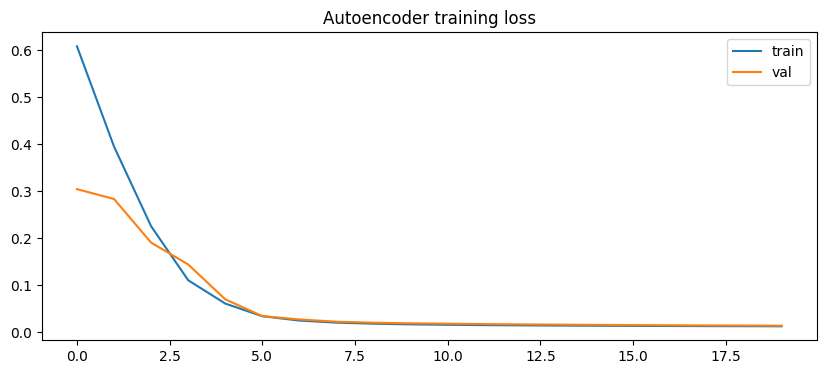

In [5]:
history = autoencoder.fit(
    X_ts, X_ts,
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.title("Autoencoder training loss")
plt.show()


In [6]:
# Use trained encoder to compute embeddings
encoder = models.Model(
    autoencoder.input,
    autoencoder.get_layer('latent').output
)

embeddings = encoder.predict(X_ts)
print("Embeddings shape:", embeddings.shape)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Embeddings shape: (600, 8)


In [7]:
# Cluster embeddings with K-Means and evaluate
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(embeddings)

sil = silhouette_score(embeddings, labels)
print("Silhouette score (embedding space):", sil)

ari = adjusted_rand_score(y_true, labels)
print("Adjusted Rand Index vs true pattern labels:", ari)


Silhouette score (embedding space): 0.9684235
Adjusted Rand Index vs true pattern labels: 1.0
